In [ ]:
from IPython.display import Image


# Estimating the Laplace-BNN predictive

**Author**: Romie Banerjee
<!-- **Last Updated**: `YYYY-MM-DD`   -->

---

## 1. Overview
A tutorial Laplace-BNNs inference and prediction. The objective is to explore **fast** estimation methods for Laplace-BNN predictives which produce **post-hoc** and **instance-level** uncertainties for high-dimensional output spaces. 

## 2. BNN
A **Bayesian neural network (BNN)** is an infinite family of neural networks, parametrized as a map $f:X \times \Theta \to Y$, where the spaces  $X$, $\Theta$ and $Y$ are respectively the imput, model and output spaces. The mapping is coordinatized as $R^n \times R^w \to R^d$. The mapping $(x, \theta) \mapsto f(x, \theta)$ expresses the evaluation of the model $\theta$ at the input $x$. The family of models is equipped with a probability measure, the posterior. The final inference step estimates the predictive distribution in the output space. 

### BNN Inference
- Given the model $\Theta$ (space of NN weights) and prior distribution $P(\Theta)$
- training data $D$
- The posterior distribution $P(\Theta |D)$, estimated by approximations (monte carlo, variational infernce etc.). 
- The BNN predictive is the output distribution on $Y$, defined as the push-forward prob measure on $\Theta$, via the map $f(x, -): \Theta \to Y$. 


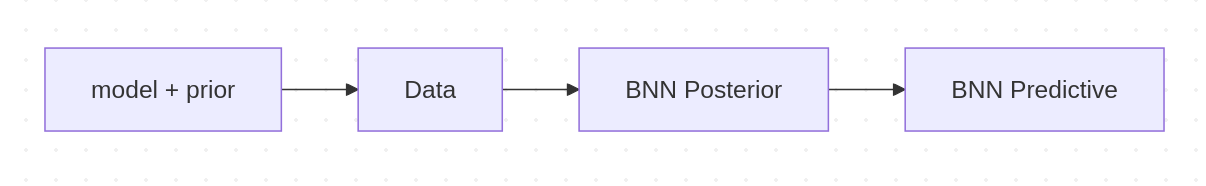

In [ ]:

# ```mermaid
# graph LR
#   A[model + prior] --> B[Data];
#   B --> C[BNN Posterior];
#   C --> D[BNN Predictive];
# ```
Image('/home/romie/ailab/mcglm/diagrams/bnn_predictive.png' , width=1000)


### BNN predictive estimator: MCI estimate [1]
The **Monte-Carlo-Itegration(MCI)**  method perfoms multiple forward passes using a sampling of models from the BNN posterior, and computes the distribution statistics in the output space.

- Input $x$
- Sample weights $\theta_1, \ldots, \theta_k \sim P(\theta | D)$
- Multiple Feed forwards  $f(x, \theta_1), \ldots, f(x, \theta_k)$
- Compute the predictive $P(y|x)$ statistics: empirical mean and covariance
- MCI predition: $ \bar{f}(x) = MEAN \left( f(x, \theta_1), \ldots, f(x, \theta_k) \right)$
- MCI covariance =  $\frac{1}{k-1}\sum_{i=1}^k \left( f(x, \theta_i) - \bar{f}(x) \right) @ \left( f(x, \theta_i) - \bar{f}(x) \right)^T$ 
- MCI is an estimator of the true predictive $P(y|x) = f(x, -)_*P(\theta|D)$ on $Y$. 
- The convergence property $\bar{f}(x) \to Exp P(y|x)$ as $k \to \infty$ follows from the CLT.


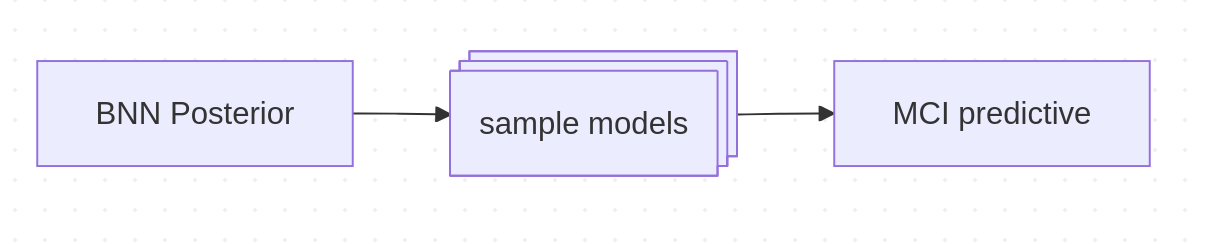

In [9]:
# ```mermaid
# graph LR
#     B[BNN Posterior]
#     D@{ shape: procs, label: "sample models"}
#     B --> D
#     D --> A[MCI predictive]
# ``` 
Image('/home/romie/ailab/mcglm/diagrams/mci_predictive.png' , width=1000)


## 3. Laplace-BNN [4]
A **Laplace-BNN** is BNN where the posterior is replaced by a *Gaussian around the MAP* using Laplace approximation applied to the true model posterior. The MAP is a model point-estimate obtained through ERM. 

### Laplace-BNN Inference 
- $ P(\Theta|D) \sim N(\theta_{MAP}, \Sigma) $
- The covariance $\Sigma$ is inverse of the Loss Hessian, $\left( \frac{\partial^2}{\partial \theta^2} Loss(\theta)|_{\theta_{MAP}} \right)^{-1}$


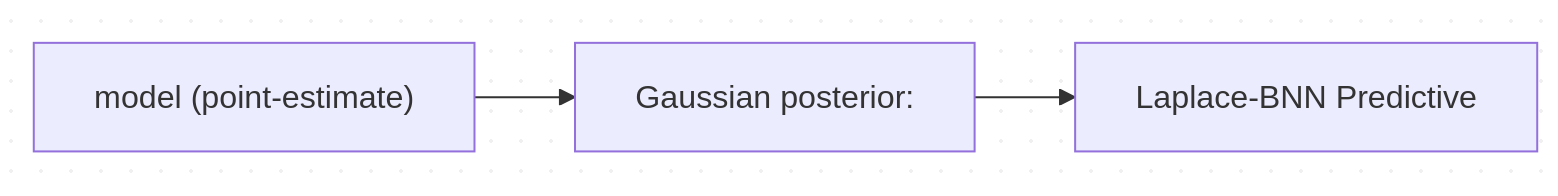

In [10]:

# ```mermaid
# graph LR
#   A["model (point-estimate)"] --> C[Gaussian posterior:];
#   C --> D[Laplace-BNN Predictive];
# ``` 
Image('/home/romie/ailab/mcglm/diagrams/laplace_BNN_predictive_0.png' , width=1000)



### Laplace-BNN Inference with KFAC posterior [5]

- The Hessian matrix is replaced by the Generalized-Gauss-Newton approximation, i.e. the Fisher information matrix $ I_{\theta}(\theta_{MAP}) := COV \left( \nabla_{\theta}Loss |_{\theta_{MAP}} \right)$
- $ P(\Theta|D) \sim N(\theta_{MAP}, I_{\theta}(\theta_{MAP})^{-1}) $$
- The Fisher is further approximated by the **KFAC** matrix, a *block-diagonal* form (block per layer), where each block is in a *kronecker-factored*  form $I_{\theta}(\theta_{MAP})_{KFAC} =
  \begin{pmatrix}
  Q_{(1)}\otimes H_{(1)}&  &\\
  & \ddots & \\
  && Q_{(L)} \otimes H_{(L)}
  \end{pmatrix}$
- The l-th block $Q_l\otimes H_l$ is the Fisher for the l-th layer. 
- The KFAC posterior covariance $\Sigma_{KFAC} = 
  \begin{pmatrix}
  Q_{(1)}^{-1}\otimes H_{(1)}^{-1}&  &\\
  & \ddots & \\
  && Q_{(L)}^{-1} \otimes H_{(L)}^{-1}
  \end{pmatrix}$
- Other variant of approximate Fisher include eKFAC and INF [3]

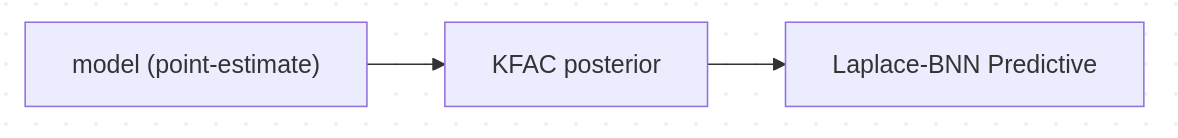

In [11]:

# ```mermaid
# graph LR
#   A["model (point-estimate)"] --> C[KFAC posterior];
#   C --> D[Laplace-BNN Predictive];
# ```
Image('/home/romie/ailab/mcglm/diagrams/laplace_BNN_predictive.png' , width=1000)



## 4. Laplace-BNN predictive estimators

### Laplace-BNN predictive: MCI estimate
- Input $x$
- Sample weights $\theta_1, \ldots, \theta_k \sim N\left( \theta_{MAP}, I_{\theta}(\theta_{MAP})^{-1}\right)$
- Multiple Feed forwards $f(x, \theta_1), \ldots, f(x, \theta_k)$
- Compute the predictive $P(y|x)$ statistics: empirical mean and covariance of $y_1, \ldots, y_k$
- *NOTE*: The MCI prediction $\bar{f}(x)$ is different from $f_{MAP}(x)$, hence the Laplace-MCI predictive doesn't say anything meaningful about the prediction uncertainty the original model $f_{MAP}$.


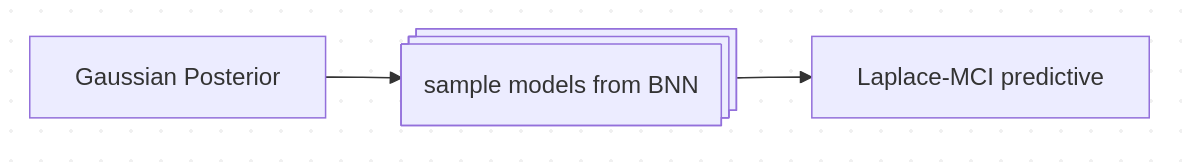

In [12]:
# ```mermaid
# graph LR
#     B[Gaussian Posterior]
#     D@{ shape: procs, label: "sample models from BNN"}
#     B --> D
#     D --> A[Laplace-MCI predictive]
# ```
Image('/home/romie/ailab/mcglm/diagrams/laplace_MCI_predictive.png' , width=1000)



### Laplace-BNN predictive: GLM [2]
The **Generalized Linear Model (GLM)** is the linearization of the BNN $f: X \times \Theta \to Y$ at $\theta = \theta_{MAP}$. 
- $f_{lin}(x, \theta) = f(x, \theta_{MAP}) + J(x)(\theta - \theta_{MAP})$
- where $J(x)$ is the jacobian $\frac{\partial}{\partial\theta} f(x, \theta)|_{\theta = \theta_{MAP}}$.
- The GLM predictive is a Gaussian: $N(f_{MAP}(x), J(x)@\Sigma @J(x)^T)$
- where $\Sigma$ is the Laplace posterior Gaussian (using GGN approximation $\Sigma = I_{\theta}(\theta_{MAP})^{-1}$)
- *NOTE*: Since the GLM predictive is a gaussian with mean $f_{MAP}(x)$, it can be read as the prediction uncertainty of the origina model $f_{MAP}$.
- *NOTE*: In order to use GLM directy (i.e. using the closed form of the GLM covariance) one has to compute $J(x)$ for every $x$, this can be compute heavy when the output space is high-dimensional. 


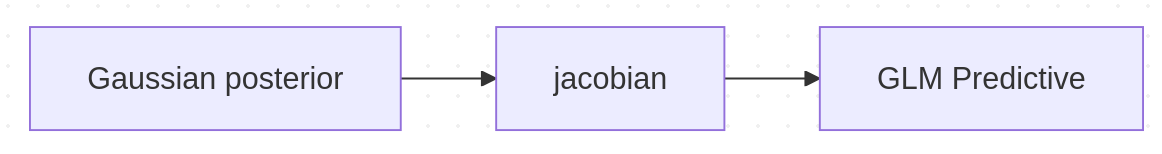

In [13]:

# ```mermaid
# graph LR
#   A["Gaussian posterior"] --> C[jacobian];
#   C --> D[GLM Predictive];
# ```
Image('/home/romie/ailab/mcglm/diagrams/glm_predictive.png' , width=1000)



### Laplace-BNN predictive: MC-GLM 
Empirically estimate the GLM predictive: apply MCI to the GLM model
- Input $x$
- Sample weights $\theta_1, \ldots, \theta_k \sim N\left( \theta_{MAP}, I_{\theta}(\theta_{MAP})^{-1}\right)$
- Multiple Feed forwards $f_{lin}(x, \theta_1), \ldots, f_{lin}(x, \theta_k)$
- Compute the GLM predictive $P(y|x)$ statistics: empirical mean and covariance
- The empirical mean, $\bar{f}_{lin}(x) = MEAN\left[ f_{lin}(x, \theta_i)\right] = f_{lin}(x, MEAN(\theta_i)) = f_{MAP}(x) + J(x)(MEAN(\theta_i) - \theta_{MAP})$, converges to $f_{MAP}(x)$
- The empirical covariance $\frac{1}{k-1}\sum_{i=1}^k \left( f_{lin}(x, \theta_i) - \bar{f}_{lin}(x) \right) @ \left( f_{lin}(x, \theta_i) - \bar{f}_{lin}(x) \right)^T$, converges to $J(x)@\Sigma @J(x)^T$
- Simplify the empirical covarinace further by $\frac{1}{k-1}\sum_{i=1}^k \left( J(x)@(\theta_i - \theta_{MAP}) \right) @ \left( J(X)@(\theta_i - \theta_{MAP}) \right)^T$
- Numerical differentiation: $J(x)@(\theta_i - \theta_{MAP}) \sim \frac{f(x, \theta_{MAP} + h*\eta_i) - f(x, \theta_{MAP})}{h}$, where $h$ is a small scalar, $\eta_i = \theta_i - \theta_{MAP}$


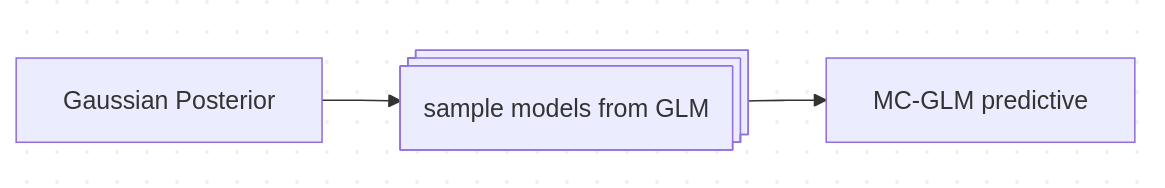

In [14]:

# ```mermaid
# graph LR
#     B[Gaussian Posterior];
#     D@{ shape: procs, label: "sample models from GLM"};
#     B --> D;
#     D --> A[MC-GLM predictive];
# ```
Image('/home/romie/ailab/mcglm/diagrams/mcglm_predictive.png' , width=1000)



### Laplace-BNN predictive: LR-GLM 
A **low-rank approximation** of the GLM predictive covariance $\Sigma(x) = J(x)@\Sigma @J(x)^T$ utilizing the sparsity of the eigenspectrum of the Fisher information matrix. 
- Input $x$
- Choose $K$ Eigen-vectors (scaled by their eigenvalues) from the TopK  $ v_1, \ldots, v_m, (K << w)$ from the high-end of the eigenspectrum of $I_{\theta}(\theta_{MAP})$
- Multiple Feed forwards $f(x, v_1), \ldots, f(x, v_m)$
- $A(x) := 
\begin{pmatrix}
| & & | \\
D_{v_1}f & \cdots & D_{v_n}f \\
| &  & |
\end{pmatrix}
\in \mathbb{R}^{d \times K}$, where $D_{v}f = \frac{f(x, \theta_{MAP} + h*v) - f(x, \theta_{MAP})}{h}$, $h$ is a small scalar
- $\Sigma(x)_{LR} = A(x)@A(x)^T$


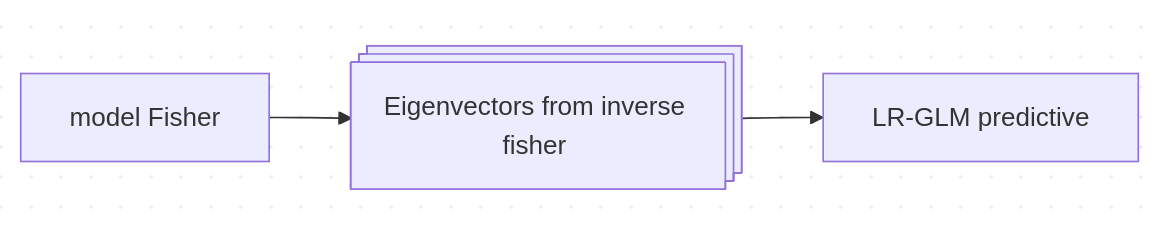

In [17]:

# ```mermaid
# graph LR
#     B[model Fisher]
#     D@{ shape: procs, label: "Eigenvectors from inverse fisher "}
#     B --> D
#     D --> A[LR-GLM predictive]
# ```
Image('/home/romie/ailab/mcglm/diagrams/lr_glm_predictive.png' , width=1000)



## 4. Additional Details

### Sampling from the Gaussian with KFAC covariance
- A sample from a gaussian $z \sim N(\mu, \Sigma)$ can be obtained by first sampling $x \sim N(0, I_n)$ from an identity-covariance zero-mean Gaussian, and appling the affine transformation $z= \mu  + Chol(\Sigma)@ x$.
- For a KFAC Laplace-BNN the covariance of the form 
  $\begin{pmatrix}
  Q_{(1)}^{-1}\otimes H_{(1)}^{-1}&  &\\
  & \ddots & \\
  && Q_{(L)}^{-1} \otimes H_{(L)}^{-1}
  \end{pmatrix}$
- The Choleksy decomposes block-wise and commutes with inverses and kronecker products: 
  $Chol\begin{pmatrix}
  Q_{(1)}^{-1}\otimes H_{(1)}^{-1}&  &\\
  & \ddots & \\
  && Q_{(L)}^{-1} \otimes H_{(L)}^{-1}
  \end{pmatrix}$ = 
$\begin{pmatrix}
Chol(Q_{(1)})^{-1}\otimes Chol(H_{(1)})^{-1}& &\\
& \ddots & \\
&& Chol(Q_{(L)})^{-1}\otimes Chol(H_{(L)})^{-1}& &\\
\end{pmatrix}$
- The samples care obtained layer-wise: $z_l = \left( Ch(Q_{(1)})^{-1}\otimes Ch(H_{(1)})^{-1} \right)@ x_l$ where $x \sim N(0, I_l)$

### Computing the closed form GLM predictive 
In order to compute the GLM closed for, one needs to compute
- The KFAC covariance matrix (independent of the input $x$)
- The Jacobian $J(x)$ 
- matrix product $J(x) @ \Sigma @ J(x)^T$

Given the block-wise kronecker-factored form of the KFAC $\Sigma$, the jacobian must be expressed in a compatible format




<!-- ```pseudocode
function BAYESIAN-INFERENCE(data, prior):
    posterior ← prior
    for each point in data:
        likelihood ← COMPUTE-LIKELIHOOD(point, posterior)
        posterior ← UPDATE(posterior, likelihood)
    return posterior
``` -->



## References

1. **Gal, Y.**, *Uncertainty in Deep Learning. PhD thesis*, University of Cambridge, 2016.

2. **Immer, Korzepa, Bauer**, *Improving predictions of bayesian neural nets via local linearization*, Proceedings of the 24th international conference on Artificial Intelligence and Statistics (AISTATS) 2021, PLMR: Volume 130, 2021.  
   [DOI/Link](https://proceedings.mlr.press/v130/immer21a)  

3. **Lee, Humt, et.al.**, *Estimating Model Uncertainty of Neural Networks in Sparse Information Form*, ICML, 2020.
   [DOI/Link] (https://arxiv.org/abs/2006.11631)

4. **Mackay**, *Bayesian model comparison and backprop-nets*, NeurIPS, 1992. 
   [DOI/Link](https://proceedings.neurips.cc/paper/1991/hash/c3c59e5f8b3e9753913f4d435b53c308-Abstract.html)  

5. **Martens, G.**, *Optimizing neural networks with kronecker-factored approximate curvature*, Proceccdings of the 32nd ICML, 2015.
    [DOI/Link](https://proceedings.mlr.press/v37/martens15.pdf)  


